In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from skimage.transform import resize

In [77]:
cols = ['Age', 'Sex', 'PositivityAtAdmission', 'Temp_C', 'DaysFever', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Fibrinogen', 'Glucose',
       'PCT', 'LDH', 'INR', 'D_dimer', 'Ox_percentage', 'PaO2', 'SaO2',
       'PaCO2', 'pH', 'CardiovascularDisease', 'IschemicHeartDisease',
       'AtrialFibrillation', 'HeartFailure', 'Ictus', 'HighBloodPressure',
       'Diabetes', 'Dementia', 'BPCO', 'Cancer', 'ChronicKidneyDisease',
       'RespiratoryFailure', 'Obesity', 'Position']

In [78]:
test_mean_mild_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/mean_mild_attentions.npy")
test_mean_severe_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/mean_severe_attentions.npy")

mean_mild_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/valid_mean_mild_attentions.npy")
mean_severe_map = np.load(
    "../data/raw_output/checkpoints_xplainable/ES_2022-10-03_15:27:54.457214/attentions/valid_mean_severe_attentions.npy")

In [79]:
mean_mild_map.shape, mean_severe_map.shape, test_mean_mild_map.shape, test_mean_severe_map.shape

((256, 35, 1), (256, 35, 1), (256, 35, 1), (256, 35, 1))

In [80]:
def reshape(inp):
    return np.moveaxis(inp.reshape(16, 16, 35), 2, 0)

mean_mild_map = reshape(mean_mild_map)
mean_severe_map = reshape(mean_severe_map)
test_mean_mild_map = reshape(test_mean_mild_map)
test_mean_severe_map = reshape(test_mean_severe_map)

mean_mild_map.shape

(35, 16, 16)

In [283]:
brixia_scores = np.array(
    [np.loadtxt(
        fname
    ).reshape(3, 2).astype(int) for fname in Path(
        "../data/preprocessed_data/train/score_original/").glob("*.txt")])


brixia_paths = np.array(
    [fname.name for fname in Path(
        "../data/preprocessed_data/train/score_original/").glob("*.txt")]).tolist()

len(brixia_scores), len(brixia_paths), len(np.unique(brixia_paths))

(1103, 1103, 1103)

In [284]:
test_brixia_scores = np.array(
    [np.loadtxt(
        fname
    ).reshape(3, 2).astype(int) for fname in Path(
        "../data/preprocessed_data/test/score_original/").glob("*.txt")])

test_brixia_paths = np.array(
    [fname.name for fname in Path(
        "../data/preprocessed_data/test/score_original/").glob("*.txt")]).tolist()

len(test_brixia_scores), len(test_brixia_paths), len(np.unique(test_brixia_paths))

(486, 486, 486)

In [285]:
prognosis = pd.read_csv(
    "../data/preprocessed_data/tables/trainClinData.csv"
)["Prognosis"].map(lambda x: int(x == "SEVERE")).values
test_prognosis = pd.read_excel(
    "../data/raw_data/completeTestClinData.xls"
)["Prognosis"].map(lambda x: int(x == "SEVERE")).values

names = pd.read_csv(
    "../data/preprocessed_data/tables/trainClinData.csv"
)["ImageFile"].map(lambda x: x.replace('.png', '.txt')).values.tolist()
test_names = pd.read_csv(
    "../data/preprocessed_data/tables/testClinData.csv"
)["ImageFile"].map(lambda x: x.replace('.png', '.txt')).values.tolist()

In [286]:
len(names), len(test_names), len(brixia_paths), len(test_brixia_paths)

(1103, 486, 1103, 486)

In [287]:
names[:5], test_names[:5], brixia_paths[:5], test_brixia_paths[:5]

(['P_102.txt', 'P_131.txt', 'P_132.txt', 'P_117.txt', 'P_16.txt'],
 ['P_3_29.txt', 'P_3_415.txt', 'P_3_163.txt', 'P_3_348.txt', 'P_3_263.txt'],
 ['P_1_27.txt', 'P_272.txt', 'P_613.txt', 'P_165.txt', 'P_504.txt'],
 ['P_3_442.txt', 'P_3_334.txt', 'P_3_493.txt', 'P_3_399.txt', 'P_3_348.txt'])

In [288]:
prognosis[:5], test_prognosis[:5]

(array([1, 0, 0, 0, 1]), array([0, 0, 0, 1, 1]))

In [289]:
indices = np.where(np.in1d(names, brixia_paths, assume_unique=True))[0]
test_indices = np.where(np.in1d(test_names, test_brixia_paths, assume_unique=True))[0]

len(indices), len(test_indices)

(1103, 486)

In [290]:
mean_severe_brixia_scores = brixia_scores[indices][np.nonzero(prognosis)]
mean_mild_brixia_scores = brixia_scores[indices][np.nonzero(1. - prognosis)]


test_mean_severe_brixia_scores = test_brixia_scores[test_indices][np.nonzero(test_prognosis)]
test_mean_mild_brixia_scores = test_brixia_scores[test_indices][np.nonzero(1. - test_prognosis)]

def mean_interpolate(arr):
    rescaled = []
    for _arr in arr:
        out = resize(_arr, (16, 16), preserve_range=True)
        rescaled.append(out)
    br_map = np.mean(np.array(rescaled), axis=0)
    # scale for covariance calc
    br_map = (br_map - np.mean(br_map))/np.std(br_map)
    return br_map

test_mean_severe_brixia_scores = mean_interpolate(test_mean_severe_brixia_scores)
test_mean_mild_brixia_scores = mean_interpolate(test_mean_mild_brixia_scores)

mean_severe_brixia_scores = mean_interpolate(mean_severe_brixia_scores)
mean_mild_brixia_scores = mean_interpolate(mean_mild_brixia_scores)

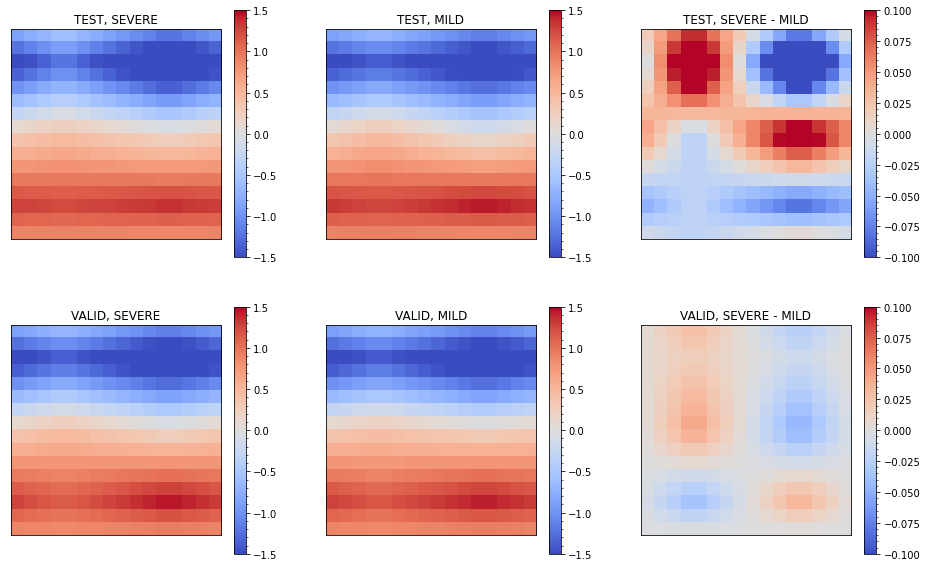

In [291]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes = axes.flatten()

cdata = axes[0].imshow(test_mean_severe_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[0].set_title('TEST, SEVERE')
cbar = plt.colorbar(cdata, ax=axes[0])
cbar.minorticks_on()
axes[0].set_xticks([])
axes[0].set_yticks([])

cdata = axes[1].imshow(test_mean_mild_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[1].set_title('TEST, MILD')
cbar = plt.colorbar(cdata, ax=axes[1])
cbar.minorticks_on()
axes[1].set_xticks([])
axes[1].set_yticks([])

cdata = axes[2].imshow(test_mean_severe_brixia_scores - test_mean_mild_brixia_scores, vmin=-.1, vmax=.1, interpolation='none', cmap='coolwarm')
axes[2].set_title('TEST, SEVERE - MILD')
cbar = plt.colorbar(cdata, ax=axes[2])
cbar.minorticks_on()
axes[2].set_xticks([])
axes[2].set_yticks([])

cdata = axes[3].imshow(mean_severe_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[3].set_title('VALID, SEVERE')
cbar = plt.colorbar(cdata, ax=axes[3])
cbar.minorticks_on()
axes[3].set_xticks([])
axes[3].set_yticks([])

cdata = axes[4].imshow(mean_mild_brixia_scores, vmin=-1.5, vmax=1.5, interpolation='none', cmap='coolwarm')
axes[4].set_title('VALID, MILD')
cbar = plt.colorbar(cdata, ax=axes[4])
cbar.minorticks_on()
axes[4].set_xticks([])
axes[4].set_yticks([])

cdata = axes[5].imshow(mean_severe_brixia_scores - mean_mild_brixia_scores, vmin=-.1, vmax=.1, interpolation='none', cmap='coolwarm')
axes[5].set_title('VALID, SEVERE - MILD')
cbar = plt.colorbar(cdata, ax=axes[5])
cbar.minorticks_on()
axes[5].set_xticks([])
axes[5].set_yticks([])

plt.show()

In [292]:
def correlation_study(arr, brixia, cols, threshold=0.0):
    for _arr, _col in zip(arr, cols):
        corr = np.correlate(_arr.flatten(), brixia.flatten())[0]
        if np.abs(corr) > threshold:
            print(f"{_col:25s} : {corr:10.4f}")

# TEST

### TEST - MILD

In [294]:
correlation_study(test_mean_mild_map, test_mean_mild_brixia_scores, cols, 0.1)

Sex                       :     0.2073
PositivityAtAdmission     :     0.2745
DaysFever                 :     0.2544
Cough                     :     0.3617
WBC                       :     0.2639
RBC                       :     0.1260
CRP                       :     0.2714
Fibrinogen                :     0.1282
Glucose                   :     0.1340
LDH                       :     0.1649
SaO2                      :     0.2988
PaCO2                     :     0.1387
ChronicKidneyDisease      :     0.1257


### TEST - SEVERE

In [295]:
correlation_study(test_mean_severe_map, test_mean_severe_brixia_scores, cols, 0.1)

Cough                     :     0.1545
Cancer                    :     0.2202


### TEST, SEVERE - MILD

In [296]:
correlation_study(test_mean_severe_map - test_mean_mild_map,
                  test_mean_severe_brixia_scores - test_mean_mild_brixia_scores,
                  cols, 0.0025)

WBC                       :     0.0025
SaO2                      :     0.0052
PaCO2                     :     0.0041
CardiovascularDisease     :    -0.0027
IschemicHeartDisease      :    -0.0031
HighBloodPressure         :    -0.0027
Diabetes                  :    -0.0031
BPCO                      :    -0.0035
Cancer                    :    -0.0054
Position                  :    -0.0032


# VALID

## VALID - MILD

In [300]:
correlation_study(mean_mild_map, mean_mild_brixia_scores, cols, 0.1)

Sex                       :     0.2252
PositivityAtAdmission     :     0.2303
DaysFever                 :     0.3021
Cough                     :     0.3631
WBC                       :     0.2902
RBC                       :     0.1753
CRP                       :     0.2851
Fibrinogen                :     0.1486
Glucose                   :     0.1637
PCT                       :     0.1238
LDH                       :     0.1700
INR                       :     0.1538
SaO2                      :     0.3424
PaCO2                     :     0.2059
ChronicKidneyDisease      :     0.1336


## VALID - SEVERE

In [301]:
correlation_study(mean_severe_map, mean_severe_brixia_scores, cols, 0.1)

Cough                     :     0.1099
Diabetes                  :     0.1026
Cancer                    :     0.2647
Obesity                   :     0.1121


## VALID, SEVERE - MILD

In [308]:
correlation_study(mean_severe_map - mean_mild_map,
                  mean_severe_brixia_scores - mean_mild_brixia_scores,
                  cols, 0.0025)

DaysFever                 :     0.0029
Cough                     :     0.0029
WBC                       :     0.0026
SaO2                      :     0.0046
PaCO2                     :     0.0034


In [312]:
###
correlation_study(mean_severe_map + mean_mild_map,
                  mean_severe_brixia_scores + mean_mild_brixia_scores,
                  cols, 0.3)

Sex                       :     0.5122
PositivityAtAdmission     :     0.3325
DaysFever                 :     0.6955
Cough                     :     0.9432
WBC                       :     0.6099
RBC                       :     0.3832
CRP                       :     0.6610
Fibrinogen                :     0.3021
Glucose                   :     0.4101
LDH                       :     0.3425
SaO2                      :     0.7914
PaCO2                     :     0.3626
Cancer                    :     0.3689
ChronicKidneyDisease      :     0.4060
